In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.api.models import Sequential
from keras.api.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.api.utils import to_categorical, image_dataset_from_directory
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.api.preprocessing import image
from keras.api.optimizers import Adam

from tensorflow._api.v2.data import Dataset

from sklearn.model_selection import StratifiedKFold, train_test_split

from typing import ByteString
from enum import Enum

from utils.model_utils import plot_image, print_history, plot_history, salvar_modelo, carregar_modelo

# Rede Neural Densa

In [2]:
dataset = pd.read_csv('./datasets/simpsons/data.csv')
dataset.head()

,laranja_camisa_bart,azul_calcao_bart,azul_sapato_bart,marrom_boca_homer,azul_calca_homer,cinza_sapato_homer,classe
0,6.886102,3.495204,1.484984,0.000000,0.0,0.062954,Bart
1,5.004901,3.183889,1.000142,0.000000,0.0,0.033024,Bart
2,5.264620,5.029683,0.283567,0.000000,0.0,0.151573,Bart
3,0.000000,0.000000,0.000000,0.480168,0.0,0.021164,Bart
4,8.978929,3.459119,0.000000,0.000000,0.0,0.011593,Bart


In [43]:
classes = list(dataset['classe'].unique())
X = dataset.drop('classe', axis=1).values
y = dataset['classe'].values
y = dataset['classe'].map(classes.index).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(234, 6)

In [55]:
def criar_modelo(shape: tuple = (6,), name='Simpsons') -> Sequential:
    modelo = Sequential(
        name=name,
        layers=[
            Input(shape=shape),
        ]
    )

    modelo.add(
        Dense(
            units=4,
            activation='tanh',
        )
    )
    modelo.add(Dropout(0.2))

    modelo.add(
        Dense(
            units=1,
            activation='sigmoid',
        )
    )

    opt = Adam(
        learning_rate=0.0001,
        clipvalue=0.5,
        weight_decay=1e-6
    )

    modelo.compile(
        optimizer=opt,
        loss='binary_crossentropy',
        metrics=[
            'accuracy'
        ]
    )

    return modelo

In [56]:
modelo = criar_modelo(shape=(6,), name='Simpsons_Denso')
modelo.summary()

Model: "Simpsons_Denso"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (132.00 B)

 Trainable params: 33 (132.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7175 - loss: 0.5197 - val_accuracy: 0.7288 - val_loss: 0.4544
Epoch 2/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7273 - loss: 0.4919 - val_accuracy: 0.7458 - val_loss: 0.4523
Epoch 3/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7061 - loss: 0.5391 - val_accuracy: 0.7627 - val_loss: 0.4503
Epoch 4/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7062 - loss: 0.5506 - val_accuracy: 0.7966 - val_loss: 0.4484
Epoch 5/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7407 - loss: 0.5028 - val_accuracy: 0.7966 - val_loss: 0.4464
Epoch 6/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7522 - loss: 0.5313 - val_accuracy: 0.8305 - val_loss: 0.4444
Epoch 7/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7809 - loss: 0.5069 - val_accuracy: 0.8305 - val_loss: 0.4426
Epoch 8/1000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7347 - loss: 0.4751 - val_accuracy: 0

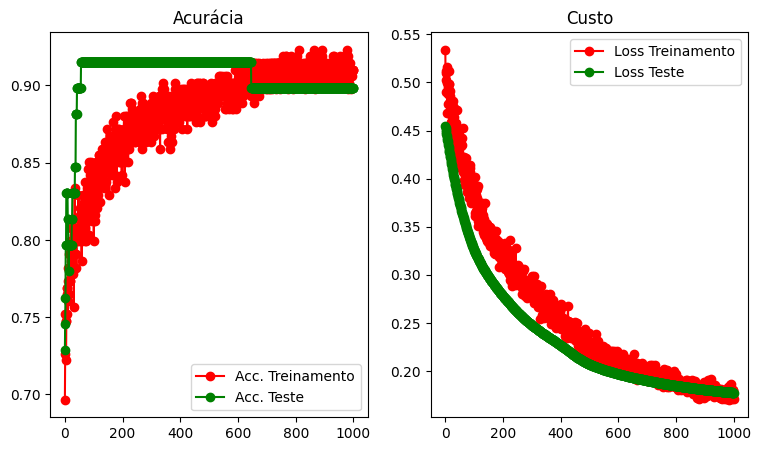

In [57]:
resultados = modelo.fit(
    x=X_train,
    y=y_train,
    batch_size=16,
    epochs=1000,
    validation_data=(X_test, y_test),
    validation_batch_size=16
)

print_history(resultados)
plot_history(resultados)
salvar_modelo(modelo, os.path.join(os.getcwd(), 'models', 'simpsons'))

# Rede Neural Convolucional

In [66]:
datasets_path = os.path.join(os.getcwd(), 'datasets', 'simpsons', 'images')

# Data agmentation virou layers....
# https://keras.io/api/layers/preprocessing_layers/image_augmentation/
gerador_treinamento = ImageDataGenerator(
    rescale = 1.0/255, # Coloca os valores de cor da imagem entre 0 e 1.
    rotation_range=7,
    horizontal_flip=True, # Rotaciona imagem
    shear_range=0.2, # Muda a direção dos pixels
    height_shift_range=0.07, # Mudança da altura
    zoom_range=0.2 # Mudança do zoom
)
gerador_teste = ImageDataGenerator(
    rescale = 1.0/255, # Coloca os valores de cor da imagem entre 0 e 1.
)

# NOVO JEITO DE IMPORTAR DADOS
# https://keras.io/api/data_loading/image/
# entradas_treino: Dataset = image_dataset_from_directory(
#     directory = os.path.join(datasets_path, 'training_set'),
#     labels='inferred',
#     label_mode='binary',
#     color_mode='grayscale',
#     batch_size=32,
#     image_size=(64, 64)
# )

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
# Por estar separado em diretórios, cachorrro e gato, é identificado automaticamente que as imagens dentro de cada pasta, 
## pertencem a class com o nome da pasta (cachorro ou gato). Pode-se adicionar novas pastas para novos targets.
dataset_treino = gerador_treinamento.flow_from_directory(
    directory= os.path.join(datasets_path, 'training_set'),
    target_size= (64, 64),
    batch_size=4,
    class_mode= 'binary'
)

dataset_teste = gerador_treinamento.flow_from_directory(
    directory= os.path.join(datasets_path, 'test_set'),
    target_size= (64, 64),
    batch_size=4,
    class_mode= 'binary'
)

Found 196 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [74]:
def criar_modelo() -> Sequential:
    # Criação modelo e entrada
    modelo = Sequential(
        name='Simpsons_Conv',
        layers=[
            Input(
                shape=(64, 64, 3)
            )
        ]
    )

    # Criação da Camada 1 de Convolução
    modelo.add(
        Conv2D(
            filters=32,
            kernel_size=(3, 3),
            padding='same',
            activation='relu' # Retira valores negativos (partes mais escuras da imagem)
        )
    )
    modelo.add(BatchNormalization())
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    # Criação da Camada 2 de Convolução
    modelo.add(
        Conv2D(
            filters=32,
            kernel_size=(4, 4),
            padding='same',
            activation='relu' # Retira valores negativos (partes mais escuras da imagem)
        )
    )
    modelo.add(BatchNormalization())
    modelo.add(
        MaxPooling2D(
            pool_size=(2, 2)
        )
    )

    # Camada de Flatten - vetorização da imagem
    modelo.add(Flatten())

    # Modelo da rede neural densa
    modelo.add(
        Dense(
            units=64,
            activation='relu'
        )
    )
    modelo.add(
        Dropout(0.2)
    )
    
    modelo.add(
        Dense(
            units=1,
            activation='sigmoid'
        )
    )

    # Método de compilação
    modelo.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    return modelo

In [75]:
modelo = criar_modelo()
modelo.summary()

Model: "Simpsons_Conv"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 541,985 (2.07 MB)

 Trainable params: 541,857 (2.07 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
46/98 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9910 - loss: 0.0357

C:\Python311\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9903 - loss: 0.0343 - val_accuracy: 0.8904 - val_loss: 0.5364
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9802 - loss: 0.0701 - val_accuracy: 0.9315 - val_loss: 0.6028
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9898 - loss: 0.0597 - val_accuracy: 0.8630 - val_loss: 0.9021
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9750 - loss: 0.0816 - val_accuracy: 0.9041 - val_loss: 0.2185
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9882 - loss: 0.0459 - val_accuracy: 0.8904 - val_loss: 0.3968
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9926 - loss: 0.0298 - val_accuracy: 0.8219 - val_loss: 0.9028
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9846 - loss: 0.0481 - val_accuracy: 0.9178 - val_loss: 0.3113
Epoch 8/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9771 - loss: 0.0562 - val_accuracy: 0.8767 - val_loss: 0.

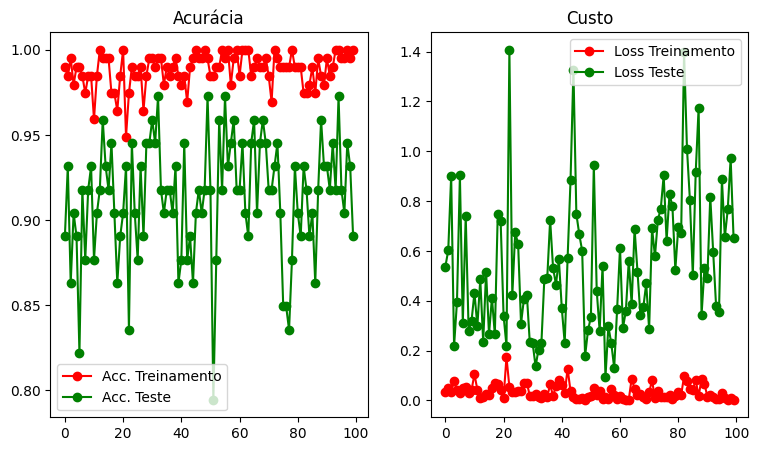

In [78]:
resultados = modelo.fit(
    x= dataset_treino,
    steps_per_epoch= int(196/2),
    epochs= 100,
    validation_data= dataset_teste,
    validation_steps= int(73/2)
)

print_history(resultados)
plot_history(resultados)
salvar_modelo(
    modelo=modelo,
    path=os.path.join(os.getcwd(), 'models', 'simpsons')
)